In [1]:
import numpy as np
import scipy.linalg as lin
from scipy import stats, signal, optimize
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle

import core
import wocca
import gradient
import visualize as vis

from ds3_sedation import *

/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/02-2010-anest 20100210 135.003.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:27: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + full_fn[0] + ".set")
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:27: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + full_fn[0] + ".set")
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:27: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + full_fn[0] + ".set")


In [2]:
import importlib
importlib.reload(vis)

<module 'visualize' from '/data/liyichao/code/microstates/wocca_project_code/visualize.py'>

In [2]:
pickle_prefix = "../wocca_project_pickles/ds3_sedation_"
bounds_fn = pickle_prefix + "bounds.pickle"
wocca_fn = pickle_prefix + "wocca.pickle"
wocca_sub_fn = pickle_prefix + "wocca_sub.pickle"
affinity_fn = pickle_prefix + "affinity.pickle"
partial_b_matrices_fn = pickle_prefix + "partial_b.pickle"
permutation_fn = pickle_prefix + "permutation.pickle"

foundation_fn = pickle_prefix + "foundation.pickle"
ds2_foundation_fn = "../wocca_project_pickles/ds2_leipzig_foundation.pickle"

with open(ds2_foundation_fn, mode = "rb") as FIn:
    ds2_info = pickle.load(FIn)[0]
info_old = info.copy()
info = vis.make_calibrated_info(ds2_info, info)

n_ch = len(info.ch_names)
unresponsive = np.array(qs < 24, dtype = int)

### Fresh start

In [3]:
# %% Load phasemaps and segment boundaries
# NOTICE: MAY TAKE SEVERAL MINUTES

v = []
bounds = [0]
ids = []

# Load data
for i in range(n_fn_full):
    tmp = iter_twms(i)
    for j in range(len(tmp)):
        v.append(tmp[j].data.copy())
        bounds.append(bounds[-1] + len(v[-1]))
        ids.append([i // 4, i % 4, j])

v = np.concatenate(v)
bounds = np.array(bounds)
ids = np.array(ids)
n_data, n_v = v.shape
n_segs = len(ids)

# Mark subject and state segments
segs_subjs = np.zeros([21], dtype = int)
segs_states = np.zeros([20, 5], dtype = int)
k = 0
for i in range(20):
    segs_states[i, 0] = k
    for j in range(4):
        while k < n_segs:
            if ids[k, 1] != j:
                break
            k += 1
        segs_states[i, j + 1] = k
    segs_subjs[i + 1] = k

# Save as pickle
with open(bounds_fn, mode = "wb") as FOut:
    pickle.dump((ids, bounds, segs_subjs, segs_states), FOut)

/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/02-2010-anest 20100210 135.003.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/02-2010-anest 20100210 135.006.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/02-2010-anest 20100210 135.014.set...
Not setting metadata
35 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/02-2010-anest- 20100210 16.003.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/03-2010-anest 20100211 142.003.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/03-2010-anest 20100211 142.008.set...
Not setting metadata
33 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/03-2010-anest 20100211 142.021.set...
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/03-2010-anest 20100211 142.026.set...
Not setting metadata
36 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/05-2010-anest 20100223 095.004.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/05-2010-anest 20100223 095.009.set...
Not setting metadata


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/05-2010-anest 20100223 095.022.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/05-2010-anest 20100223 095.027.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/06-2010-anest 20100224 093.003.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/06-2010-anest 20100224 093.008.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/06-2010-anest 20100224 093.013.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/06-2010-anest 20100224 093.026.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/07-2010-anest 20100226 133.003.set...
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/07-2010-anest 20100226 133.008.set...
Not setting metadata
30 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/07-2010-anest 20100226 133.021.set...
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/07-2010-anest 20100226 133.027.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/08-2010-anest 20100301 095.004.set...
Not setting metadata
37 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/08-2010-anest 20100301 095.010.set...
Not setting metadata
39 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/08-2010-anest 20100301 095.015.set...
Not setting metadata
36 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/08-2010-anest 20100301 095.028.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/09-2010-anest 20100301 135.003.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/09-2010-anest 20100301 135.008.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/09-2010-anest 20100301 135.021.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/09-2010-anest 20100301 135.026.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/10-2010-anest 20100305 130.005.set...
Not setting metadata
33 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/10-2010-anest 20100305 130.010.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/10-2010-anest 20100305 130.015.set...
Not setting metadata
37 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/10-2010-anest 20100305 130.028.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/13-2010-anest 20100322 132.003.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/13-2010-anest 20100322 132.008.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/13-2010-anest 20100322 132.013.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/13-2010-anest 20100322 132.026.set...
Not setting metadata
39 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/14-2010-anest 20100324 125.007.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/14-2010-anest 20100324 132.011.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/14-2010-anest 20100324 132.016.set...
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/14-2010-anest 20100324 132.031.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/18-2010-anest 20100331 140.003.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/18-2010-anest 20100331 140.009.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/18-2010-anest 20100331 140.014.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/18-2010-anest 20100331 140.027.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/20-2010-anest 20100414 131.004.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/20-2010-anest 20100414 131.009.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/20-2010-anest 20100414 131.022.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/20-2010-anest 20100414 131.027.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/22-2010-anest 20100415 132.004.set...
Not setting metadata
36 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/22-2010-anest 20100415 132.009.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/22-2010-anest 20100415 132.014.set...
Not setting metadata
40 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/22-2010-anest 20100415 154.003.set...
Not setting metadata
39 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/23-2010-anest 20100420 094.003.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/23-2010-anest 20100420 094.008.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/23-2010-anest 20100420 094.022.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/23-2010-anest 20100420 094.027.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/24-2010-anest 20100420 134.003.set...
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()



EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/24-2010-anest 20100420 134.010.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/24-2010-anest 20100420 134.015.set...
Not setting metadata
38 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/24-2010-anest 20100420 134.028.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/25-2010-anest 20100422 133.003.set...
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/25-2010-anest 20100422 133.008.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/25-2010-anest 20100422 133.021.set...
Not setting metadata
36 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/25-2010-anest 20100422 133.026.set...
Not setting metadata
34 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/26-2010-anest 20100507 132.003.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/26-2010-anest 20100507 132.008.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/26-2010-anest 20100507 132.013.set...
Not setting metadata
40 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/26-2010-anest 20100507 132.026.set...
Not setting metadata
41 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/27-2010-anest 20100823 104.001.set...
Not setting metadata
38 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/27-2010-anest 20100823 104.010.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/27-2010-anest 20100823 104.023.set...
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Ready.


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/27-2010-anest 20100823 104.028.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/28-2010-anest 20100824 092.004.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/28-2010-anest 20100824 092.011.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/28-2010-anest 20100824 092.016.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/28-2010-anest 20100824 092.029.set...
Not setting metadata
39 matching events found


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/29-2010-anest 20100921 142.005.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/29-2010-anest 20100921 142.010.set...
Not setting metadata
30 matching events found
No baseline correction applied


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/29-2010-anest 20100921 142.023.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/29-2010-anest 20100921 142.028.set...


/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [4]:
# %% Common functions and definitions for WOCCA

def extend_parameter(p):
    r = np.zeros([n_data], dtype = p.dtype)
    for i in range(20):
        for j in range(4):
            r[bounds[segs_states[i, j]] : bounds[segs_states[i, j + 1]]] = p[i * 4 + j]
    
    return r

n_comps = 10
n_comps_ext = 15
n_dim_pca = 30
tri_mask = wocca.upper_triangle(n_dim_pca)

weights = np.array(extend_parameter(ppfc), dtype = float)
weights -= weights.mean()

In [5]:
# %% WOCCA and EW-WOCCA on complete data
# NOTICE: MAY TAKE HOURS WITHOUT GPU, OR SEVERAL MINUTES WITH GPU

u, pca_basis = wocca.pca_decomp(v, n_dim_pca)

# Pre-calculate b and bw matrices using GPU
b = wocca.get_b_matrix(u, tri_mask, use_torch = True)
bw = wocca.get_b_matrix(u, tri_mask, weights = weights, use_torch = True)

# WOCCA
ws_pca = wocca.wocca(None, b = b, n_components = n_comps_ext, use_torch = True, backtrack = True)
ws = wocca.pca_recover(ws_pca[ : n_comps], pca_basis)

# EW-WOCCA
ws_ew_pca = wocca.ew_wocca(None, None, bw = bw, n_components = n_comps_ext, use_torch = True, backtrack = True, backtrack_max_iter = 50)
ws_ew = wocca.pca_recover(ws_ew_pca[ : n_comps], pca_basis)

# Total energy and scores
total_energy = wocca.total_energy(v)
scores = wocca.score(v, ws)
scores_ew = wocca.score(v, ws_ew)

print(total_energy)
for i in range(n_comps):
    print("Score: {:.2f}, Percentage: {:.2f}%".format(scores[i], scores[i] / total_energy * 100))
for i in range(n_comps):
    print("Score of EW-WOCCA components: {:.2f}, Percentage: {:.2f}%".format(scores_ew[i], scores_ew[i] / total_energy * 100))

# Energy by segments
seg_energy = np.array([wocca.total_energy(v[bounds[i] : bounds[i + 1]]) for i in range(n_segs)])

# Finalize
del(u)

Using GPU: True
Using GPU: True
Iter 1 / 15
No. of iters 36
Score 90636.31553195226 

Iter 2 / 15
No. of iters 32
Score 83051.6105689615 

Iter 3 / 15
No. of iters 27
Score 38734.493235194335 

Iter 4 / 15
No. of iters 54
Score 19096.664370796545 

Iter 5 / 15
No. of iters 35
Score 13584.014535825956 

Iter 6 / 15
No. of iters 61
Score 9831.942875078243 

Iter 7 / 15
No. of iters 36
Score 8822.374900933064 

Iter 8 / 15
No. of iters 50
Score 8026.154756049662 

Iter 9 / 15
No. of iters 56
Score 7369.200274750664 

Iter 10 / 15
No. of iters 265
Score 6453.213069731053 

Iter 11 / 15
No. of iters 82
Score 5752.828659733049 

Iter 12 / 15
No. of iters 120
Score 5670.875326127169 

Iter 13 / 15
No. of iters 319
Score 4191.644331278751 

Iter 14 / 15
No. of iters 135
Score 4002.497028779494 

Iter 15 / 15
No. of iters 169
Score 3918.0977659361006 

Iter 1 / 15
No. of iters 34
Score 3902614.3387678135 

Iter 2 / 15
No. of iters 71
Score 2741872.141155205 

Iter 3 / 15
No. of iters 65
Score 2

In [8]:
# %% Manually correct WOCCA and EW-WOCCA directions and save components

# Invert component directions to (CCw/Cw, FW/BW, RW/LW)
manual_correction = [True, False, False, False]
manual_correction_ew = [True, True, True, False]

for i in range(len(manual_correction)):
    if manual_correction[i]:
        ws[i] = np.conj(ws[i])
for i in range(len(manual_correction_ew)):
    if manual_correction_ew[i]:
        ws_ew[i] = np.conj(ws_ew[i])

# Save as pickle
with open(wocca_fn, mode = "wb") as FOut:
    pickle.dump((seg_energy, ws, ws_ew, scores, scores_ew, b, bw), FOut)

In [12]:
# %% Calculate and save WOCCA and EW-WOCCA component affinities

n_comp_save = 5

pm_basis = []
pm_basis_ew = []
for i in range(n_comp_save):
    pm_basis += [ws[i], np.conj(ws[i])]
    pm_basis_ew += [ws_ew[i], np.conj(ws_ew[i])]
pm_basis = np.array(pm_basis)
pm_basis_ew = np.array(pm_basis_ew)
affs = core.topomap_affinity(v, pm_basis, False, True)
affs_ew = core.topomap_affinity(v, pm_basis_ew, False, True)

# Save as pickle
with open(affinity_fn, mode = "wb") as FOut:
    pickle.dump((affs, affs_ew), FOut)

In [13]:
# %% Vanilla WOCCA on subsets

# WOCCA of each state
ws_states = np.zeros([n_states, n_comps, n_ch], dtype = complex)
total_energy_states = np.zeros([n_states])
scores_states = np.zeros([n_states, n_comps])
for i in range(n_states):
    tmp_v_sub = []
    for j in range(n_subjs):
        tmp_v_sub.append(v[bounds[segs_states[j, i]] : bounds[segs_states[j, i + 1]]])
    tmp_v_sub = np.concatenate(tmp_v_sub)
    
    u, pca_basis = wocca.pca_decomp(tmp_v_sub, n_dim_pca)
    tmp_ws_pca = wocca.wocca(u, n_components = n_comps_ext, use_torch = True, backtrack = True)
    ws_states[i] = wocca.pca_recover(tmp_ws_pca[ : n_comps], pca_basis)

    total_energy_states[i] = wocca.total_energy(tmp_v_sub)
    scores_states[i] = wocca.score(tmp_v_sub, ws_states[i])

# WOCCA of unresponsive group
tmp_v_sub = []
for j in range(n_subjs):
    for k in range(n_states):
        if unresponsive[j * n_states + k] == 1:
            tmp_v_sub.append(v[bounds[segs_states[j, k]] : bounds[segs_states[j, k + 1]]])
tmp_v_sub = np.concatenate(tmp_v_sub)

u, pca_basis = wocca.pca_decomp(tmp_v_sub, n_dim_pca)
tmp_ws_pca = wocca.wocca(u, n_components = n_comps_ext, use_torch = True, backtrack = True)
ws_unresp = wocca.pca_recover(tmp_ws_pca[ : n_comps], pca_basis)

total_energy_unresp = wocca.total_energy(tmp_v_sub)
scores_unresp = wocca.score(tmp_v_sub, ws_unresp)

# Finalize
del(u)
del(tmp_ws_pca)
del(tmp_v_sub)

Using GPU: True
Iter 1 / 15
No. of iters 28
Score 22875.993173170496 

Iter 2 / 15
No. of iters 32
Score 20514.900789068106 

Iter 3 / 15
No. of iters 28
Score 9074.87403068879 



/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Iter 4 / 15
No. of iters 53
Score 4828.620356184688 

Iter 5 / 15
No. of iters 44
Score 3425.2686012229924 

Iter 6 / 15
No. of iters 65
Score 2381.641674827031 

Iter 7 / 15
No. of iters 61
Score 2133.248322960551 

Iter 8 / 15
No. of iters 53
Score 2109.7942516812286 

Iter 9 / 15
No. of iters 137
Score 1706.9956932817029 

Iter 10 / 15
No. of iters 209
Score 1675.5221967705336 

Iter 11 / 15
No. of iters 187
Score 1363.8663479289305 

Iter 12 / 15
No. of iters 51
Score 1388.2393794751902 

Score not decreasing
Backtrack to Iter 11 

Iter 11 / 15
No. of iters 39
Score 1389.4187341056718 

Iter 12 / 15
No. of iters 307
Score 1362.472426587676 

Iter 13 / 15
No. of iters 169
Score 1076.1655339313118 

Iter 14 / 15
No. of iters 236
Score 1080.9977383767846 

Score not decreasing
Backtrack to Iter 13 

Iter 13 / 15
No. of iters 41
Score 1101.984340645091 

Iter 14 / 15
No. of iters 173
Score 1068.0666347033646 

Iter 15 / 15
No. of iters 165
Score 1031.654781506963 

Using GPU: True
Iter

In [15]:
# %% Manually correct subset WOCCA directions and save components

# Invert component directions to (CCw/Cw, FW/BW, RW/LW)
manual_correction_states = [[True, False, False, False], \
                            [True, False, True, False], \
                            [True, True, True, True], \
                            [True, False, False, False]]
manual_correction_unresp = [True, True, False, True]

for k in range(n_states):
    for i in range(len(manual_correction_states)):
        if manual_correction_states[k][i]:
            ws_states[k, i] = np.conj(ws_states[k, i])
for i in range(len(manual_correction_unresp)):
    if manual_correction_unresp[i]:
        ws_unresp[i] = np.conj(ws_unresp[i])

# Save as pickle
with open(wocca_sub_fn, mode = "wb") as FOut:
    pickle.dump((total_energy_states, total_energy_unresp, ws_states, ws_unresp, scores_states, scores_unresp), FOut)

### Load previous results

In [3]:
with open(bounds_fn, mode = "rb") as FIn:
    ids, bounds, segs_subjs, segs_states = pickle.load(FIn)
n_segs = len(ids)

with open(wocca_fn, mode = "rb") as FIn:
    seg_energy, ws, ws_ew, scores, scores_ew, b, bw = pickle.load(FIn)
n_comps, n_ch = ws.shape
total_energy = seg_energy.sum()

with open(affinity_fn, mode = "rb") as FIn:
    affs, affs_ew = pickle.load(FIn)
n_data_full = len(affs)
n_comp_save = affs.shape[1] // 2
pm_basis = []
pm_basis_ew = []
for i in range(n_comp_save):
    pm_basis += [ws[i], np.conj(ws[i])]
    pm_basis_ew += [ws_ew[i], np.conj(ws_ew[i])]
pm_basis = np.array(pm_basis)
pm_basis_ew = np.array(pm_basis_ew)

with open(wocca_sub_fn, mode = "rb") as FIn:
    total_energy_states, total_energy_unresp, ws_states, ws_unresp, scores_states, scores_unresp = pickle.load(FIn)

projs = np.zeros([n_data_full, n_comp_save])
projs_ew = np.zeros_like(projs)
for i in range(n_comp_save):
    projs[ : , i] = np.abs(affs[ : , i * 2]) ** 2 - np.abs(affs[ : , i * 2 + 1]) ** 2
    projs_ew[ : , i] = np.abs(affs_ew[ : , i * 2]) ** 2 - np.abs(affs_ew[ : , i * 2 + 1]) ** 2

### Analysis of WOCCA phasemaps

In [4]:
# %% Visualization functions

fig_path = "../wocca_project_figs/explore_sedation/"
fig_supp_path = "../wocca_project_figs/supplementary/"
comp_labels = ["Rot.", "Longi.", "Horiz.", "Lat.", "Comp.5"]
comp_names = ["rot", "fw", "rw", "fs", "c5"]
comp_labels_ew = ["Longi.", "Rot.A.", "Rot.P.", "Horiz.", "Comp.5"]
comp_names_ew = ["fw", "ra", "rp", "rw", "c5"]
state_names_full = ["Baseline", "Mild", "Moderate", "Recovery"]
axis_labels = [comp_labels_ew[0], comp_labels_ew[3], "RA index"]

default_color = "#607280"
state_colors = ["#49ADFF", "#B38BFF", "#E594D8", "#B2E589"]
unresp_color = "#FF6B5C"
diagram_scatter_color = "#4A86C8"
scree_bar_wocca_color = "#4A86C8"
scree_bar_general_color = "#607280"
scree_accumulated_color = "#800E20"

(<Figure size 523x260 with 2 Axes>,
 <Axes: xlabel='Propofol concentration-weighted WOCs', ylabel='Explained TE'>,
 <Axes: ylabel='Accumulated'>)

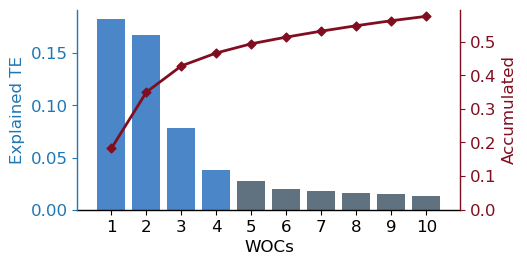

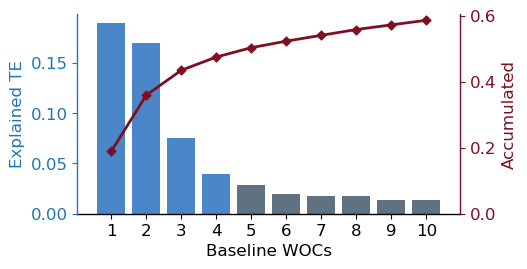

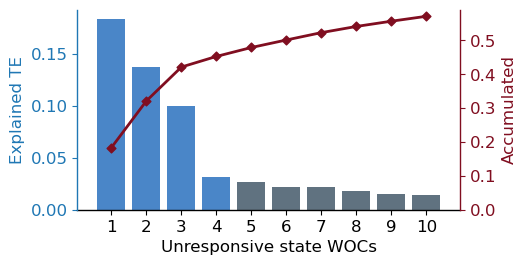

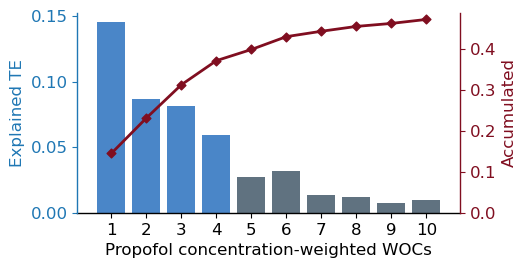

In [6]:
# %% Scree plot of WOCCA and EW-WOCCA

scree_args = dict(classes = np.array([0] * 4 + [1] * 6), class_colors = [scree_bar_wocca_color, scree_bar_general_color], acc_color = scree_accumulated_color, dpi = 100)

vis.draw_scree_plot(scores / total_energy, xlabel = "WOCs", **scree_args)
vis.draw_scree_plot(scores_states[0] / total_energy_states[0], xlabel = "Baseline WOCs", **scree_args)
vis.draw_scree_plot(scores_unresp / total_energy_unresp, xlabel = "Unresponsive state WOCs", **scree_args)
vis.draw_scree_plot(scores_ew / total_energy, xlabel = "Propofol concentration-weighted WOCs", **scree_args)

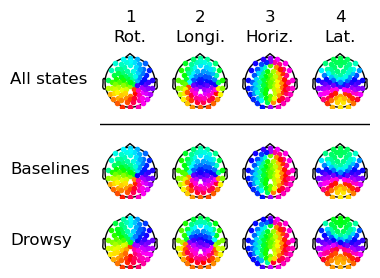

In [7]:
# %% Draw component phasemaps

# Align phase
v = np.stack([ws, ws_states[0], ws_unresp])
for i in range(1, 3):
    for j in range(4):
        v[i, j] *= np.exp(1j * np.angle(core.topomap_affinity(v[0, j], v[i, j], True, True)))

# Draw
fx, fy = 3.7, 2.7
fig = plt.figure(figsize = [fx, fy], dpi = 100)
for k in range(3):
    y0 = [1.6, 0.7, 0][k]
    head_str = ["All states", "Baselines", "Drowsy"][k]
    for i in range(4):
        ax = plt.axes([(0.7 * i + 1) / fx, y0 / fy, 0.6 / fx, 0.6 / fy])
        vis.disp_phasemap(info, v[k, i], markersize = 6)
    fig.text(0.1 / fx, (y0 + 0.3) / fy, head_str, ha = "left", va = "center", size = "large")

ax = plt.axes([1 / fx, 1.4 / fy, 2.7 / fx, 0.1 / fy])
plt.axis([0, 2.7, 0, 0.1])
plt.axhline(y = 0.05, lw = 1, c = "#000000")
vis.no_axes(ax)

for i in range(4):
    xi = 0.7 * i + 0.3 + 1
    fig.text(xi / fx, 2.45 / fy, "{:}".format(i + 1), ha = "center", va = "bottom", size = "large")
    fig.text(xi / fx, 2.25 / fy, comp_labels[i], ha = "center", va = "bottom", size = "large")

fig.savefig(fig_path + "wocca_phasemaps.svg", format = "svg")

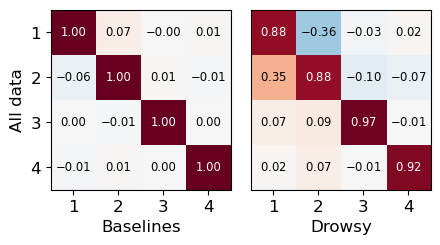

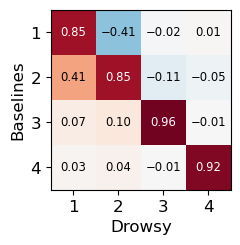

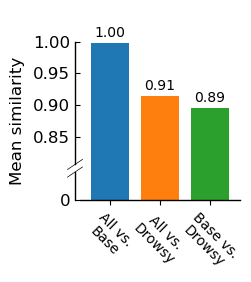

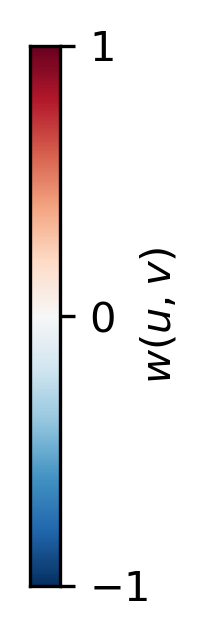

In [51]:
# %% Draw phasemap comparisons

# Compute similarity with baseline
sim = np.zeros([2, 4, 4])
for i in range(4):
    for j in range(4):
        sim[0, i, j] = wocca.w(ws[i], ws_states[0, j])
        sim[1, i, j] = wocca.w(ws[i], ws_unresp[j])

# Draw comparison with baseline
fx, fy = 4.5, 2.5
fig = plt.figure(figsize = [fx, fy], dpi = 100)
ax = plt.axes([0.6 / fx, 0.6 / fy, 1.8 / fx, 1.8 / fy])
plt.imshow(sim[0], vmin = -1, vmax = 1, cmap = "RdBu_r")
for i in range(4):
    for j in range(4):
        plt.text(j, i, "{:.2f}".format(sim[0, i, j]).replace("-", vis.minus_sign), ha = "center", va = "center", size = "small", \
                 c = "#000000" if vis.luminance(mpl.colormaps.get_cmap("RdBu_r")((sim[0, i, j] + 1) / 2)) > 0.5 else "#FFFFFF")
plt.ylabel("All data", size = "large")
plt.xlabel("Baselines", size = "large")
ax.tick_params(labelsize = "large")
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(["{:}".format(i + 1) for i in range(4)])
ax.set_yticklabels(["{:}".format(i + 1) for i in range(4)])

ax = plt.axes([2.6 / fx, 0.6 / fy, 1.8 / fx, 1.8 / fy])
plt.imshow(sim[1], vmin = -1, vmax = 1, cmap = "RdBu_r")
for i in range(4):
    for j in range(4):
        plt.text(j, i, "${:.2f}$".format(sim[1, i, j]).replace("-", vis.minus_sign), ha = "center", va = "center", size = "small", \
                 c = "#000000" if vis.luminance(mpl.colormaps.get_cmap("RdBu_r")((sim[1, i, j] + 1) / 2)) > 0.5 else "#FFFFFF")
plt.xlabel("Drowsy", size = "large")
ax.tick_params(labelsize = "large")
ax.set_xticks(np.arange(4))
ax.set_yticks([])
ax.set_xticklabels(["{:}".format(i + 1) for i in range(4)])

fig.savefig(fig_supp_path + "sedation_phasemaps_similarity_to_baseline.svg", format = "svg")

# Compute and draw similarity between two groups
sim_b = np.zeros([4, 4])
for i in range(4):
    for j in range(4):
        sim_b[i, j] = wocca.w(ws_states[0, i], ws_unresp[j])

fx, fy = 2.5, 2.5
fig = plt.figure(figsize = [fx, fy], dpi = 100)
ax = plt.axes([0.6 / fx, 0.6 / fy, 1.8 / fx, 1.8 / fy])
plt.imshow(sim_b, vmin = -1, vmax = 1, cmap = "RdBu_r")
for i in range(4):
    for j in range(4):
        plt.text(j, i, "{:.2f}".format(sim_b[i, j]).replace("-", vis.minus_sign), ha = "center", va = "center", size = "small", \
                 c = "#000000" if vis.luminance(mpl.colormaps.get_cmap("RdBu_r")((sim_b[i, j] + 1) / 2)) > 0.5 else "#FFFFFF")
plt.ylabel("Baselines", size = "large")
plt.xlabel("Drowsy", size = "large")
ax.tick_params(labelsize = "large")
ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(["{:}".format(i + 1) for i in range(4)])
ax.set_yticklabels(["{:}".format(i + 1) for i in range(4)])

fig.savefig(fig_path + "wocca_phasemaps_similarity.svg", format = "svg")

# Comparisons
fx, fy = 2.5, 2.7
fig = plt.figure(figsize = [fx, fy])
ax = plt.axes([0.8 / fx, 0.7 / fy, 1.6 / fx, 1.9 / fy])
plt.axis([-0.6, 2.6, 0.75, 1.05])
tmp_mean = np.diag(sim[0]).mean()
plt.bar(0, tmp_mean, width = 0.75, color = vis.colors[0], lw = 0)
plt.text(0, tmp_mean + 0.005, "{:.2f}".format(tmp_mean), ha = "center", va = "bottom", size = "medium")
tmp_mean = np.diag(sim[1]).mean()
plt.bar(1, tmp_mean, width = 0.75, color = vis.colors[1], lw = 0)
plt.text(1, tmp_mean + 0.005, "{:.2f}".format(tmp_mean), ha = "center", va = "bottom", size = "medium")
tmp_mean = np.diag(sim_b).mean()
plt.bar(2, tmp_mean, width = 0.75, color = vis.colors[2], lw = 0)
plt.text(2, tmp_mean + 0.005, "{:.2f}".format(tmp_mean), ha = "center", va = "bottom", size = "medium")
ax.set_frame_on(False)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["All vs.\nBase", "All vs.\nDrowsy", "Base vs.\nDrowsy"], rotation = -45, ha = "center", va = "top", size = "medium")
ax.set_yticks([0.75, 0.85, 0.9, 0.95, 1])
ax.set_yticklabels(["0", "0.85", "0.90", "0.95", "1.00"], size = "large")
tmp_delta = 0.04 / 2
plt.axvline(x = -0.7, ymax = 0.05 / 0.3 - tmp_delta, lw = 1, c = "#000000", clip_on = False)
plt.axvline(x = -0.7, ymin = 0.05 / 0.3 + tmp_delta, ymax = 0.25 / 0.3, lw = 1, c = "#000000", clip_on = False)
plt.axhline(y = 0.75, lw = 1, c = "#000000", clip_on = False)
plt.plot([-0.85, -0.55], [0.8 - tmp_delta * 0.3 - 0.008, 0.8 - tmp_delta * 0.3 + 0.008], lw = 0.5, c = "#000000", clip_on = False)
plt.plot([-0.85, -0.55], [0.8 + tmp_delta * 0.3 - 0.008, 0.8 + tmp_delta * 0.3 + 0.008], lw = 0.5, c = "#000000", clip_on = False)
fig.text(0.1 / fx, (0.7 + 1.9 / 0.3 * 0.25 / 2) / fy, "Mean similarity", size = "large", rotation = 90, ha = "left", va = "center")
fig.savefig(fig_supp_path + "sedation_similarity_bar.svg", format = "svg")

# Draw colorbar
fig = vis.colorbar("RdBu_r", fs = [0.6, 2], bs = [0.1, 1.8], ticks = np.array([-1, 0, 1]), vmin = -1, vmax = 1, \
                   tick_labels = ["${:.0f}$".format(i) for i in [-1, 0, 1]], caption = "$w(u,v)$")
fig.savefig(fig_path + "wocca_phasemaps_similarity_colorbar.svg", format = "svg")
fig.savefig(fig_supp_path + "sedation_phasemaps_similarity_colorbar.svg", format = "svg")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
[ 0.08470056 -0.08496965] [ 0.00789637 -0.00648327]
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
[ 0.07021882 -0.09885484] [-0.10440735 -0.99453462]
[ 0.00684575 -0.0223355 ] [-0.09828872 -0.99515794]
Could not find a

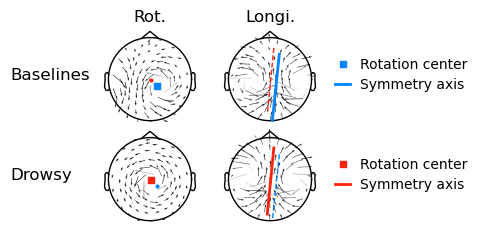

In [9]:
# %% Draw phasemap rotation center comparisons

# Fit rotation centers
rc_s0 = gradient.fit_rotation_center(info, ws_states[0, 0], target = 1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
rc_unresp = gradient.fit_rotation_center(info, ws_unresp[0], target = 1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
print(rc_s0, rc_unresp)

tmp1 = gradient.fit_rotation_center(info, ws_states[0, 1], target = 1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
tmp2 = gradient.fit_rotation_center(info, ws_states[0, 1], target = -1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
tc_s0 = (tmp1 + tmp2) / 2
tmp_d = tmp1 - tmp2
td_s0 = np.array([-tmp_d[1], tmp_d[0]]) / np.sqrt((tmp_d ** 2).sum())

tmp1 = gradient.fit_rotation_center(info, ws_unresp[1], target = 1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
tmp2 = gradient.fit_rotation_center(info, ws_unresp[1], target = -1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
tc_unresp = (tmp1 + tmp2) / 2
tmp_d = tmp1 - tmp2
td_unresp = np.array([-tmp_d[1], tmp_d[0]]) / np.sqrt((tmp_d ** 2).sum())
print(tc_s0, td_s0)
print(tc_unresp, td_unresp)

# Draw
tmp_s0_c = vis.sat_mod_white(state_colors[0], 0.5)
tmp_unresp_c = vis.sat_mod_white(unresp_color, 0.5)
fx, fy = 4.8, 2.3
fig = plt.figure(figsize = [fx, fy])

# Rotations
ax = plt.axes([1 / fx, 1.1 / fy, 1 / fx, 1 / fy])
vis.disp_quiver_map(info, ws_states[0, 0], show_r2 = True, sensors = False, scale = 60, width = 0.006)
plt.scatter(rc_s0[0], rc_s0[1], s = 15, marker = "s", c = tmp_s0_c)
plt.scatter(rc_unresp[0], rc_unresp[1], s = 15, marker = ".", c = tmp_unresp_c)

ax = plt.axes([1 / fx, 0.1 / fy, 1 / fx, 1 / fy])
vis.disp_quiver_map(info, ws_unresp[0], show_r2 = True, sensors = False, scale = 60, width = 0.006)
plt.scatter(rc_s0[0], rc_s0[1], s = 15, marker = ".", c = tmp_s0_c)
plt.scatter(rc_unresp[0], rc_unresp[1], s = 15, marker = "s", c = tmp_unresp_c)

# Longitudinal
ax = plt.axes([2.2 / fx, 1.1 / fy, 1 / fx, 1 / fy])
vis.disp_quiver_map(info, ws_states[0, 1], show_r2 = True, sensors = False, scale = 60, width = 0.006)
plt.plot([tc_s0[0] - td_s0[0] * 0.4, tc_s0[0] + td_s0[0] * 0.4], [tc_s0[1] - td_s0[1] * 0.4, tc_s0[1] + td_s0[1] * 0.4], \
         lw = 2, c = tmp_s0_c)
plt.plot([tc_unresp[0] - td_unresp[0] * 0.4, tc_unresp[0] + td_unresp[0] * 0.4], [tc_unresp[1] - td_unresp[1] * 0.4, tc_unresp[1] + td_unresp[1] * 0.4], \
         lw = 1, c = tmp_unresp_c, ls = "--")

ax = plt.axes([2.2 / fx, 0.1 / fy, 1 / fx, 1 / fy])
vis.disp_quiver_map(info, ws_unresp[1], show_r2 = True, sensors = False, scale = 60, width = 0.006)
plt.plot([tc_s0[0] - td_s0[0] * 0.4, tc_s0[0] + td_s0[0] * 0.4], [tc_s0[1] - td_s0[1] * 0.4, tc_s0[1] + td_s0[1] * 0.4], \
         lw = 1, c = tmp_s0_c, ls = "--")
plt.plot([tc_unresp[0] - td_unresp[0] * 0.4, tc_unresp[0] + td_unresp[0] * 0.4], [tc_unresp[1] - td_unresp[1] * 0.4, tc_unresp[1] + td_unresp[1] * 0.4], \
         lw = 2, c = tmp_unresp_c)

fig.text(0.1 / fx, 1.6 / fy, "Baselines", ha = "left", va = "center", size = "large")
fig.text(0.1 / fx, 0.6 / fy, "Drowsy", ha = "left", va = "center", size = "large")
fig.text(1.5 / fx, 2.1 / fy, comp_labels[0], ha = "center", va = "bottom", size = "large")
fig.text(2.7 / fx, 2.1 / fy, comp_labels[1], ha = "center", va = "bottom", size = "large")

# Integrated legend
ax = plt.axes([3.3 / fx, 1.4 / fy, 1.5 / fx, 0.4 / fy])
vis.no_axes(ax)
plt.axis([0, 1.5, 0, 0.4])
plt.plot([0.05, 0.2], [0.1, 0.1], lw = 2, c = tmp_s0_c)
plt.text(0.3, 0.1, "Symmetry axis", ha = "left", va = "center", size = "medium")
plt.scatter([0.125], [0.3], s = 15, c = tmp_s0_c, marker = "s")
plt.text(0.3, 0.3, "Rotation center", ha = "left", va = "center", size = "medium")

ax = plt.axes([3.3 / fx, 0.4 / fy, 1.5 / fx, 0.4 / fy])
vis.no_axes(ax)
plt.axis([0, 1.5, 0, 0.4])
plt.plot([0.05, 0.2], [0.1, 0.1], lw = 2, c = tmp_unresp_c)
plt.text(0.3, 0.1, "Symmetry axis", ha = "left", va = "center", size = "medium")
plt.scatter([0.125], [0.3], s = 15, c = tmp_unresp_c, marker = "s")
plt.text(0.3, 0.3, "Rotation center", ha = "left", va = "center", size = "medium")

fig.savefig(fig_path + "wocca_gradient_analysis.svg", format = "svg")

### Analysis of EW-WOCCA phasemaps and components

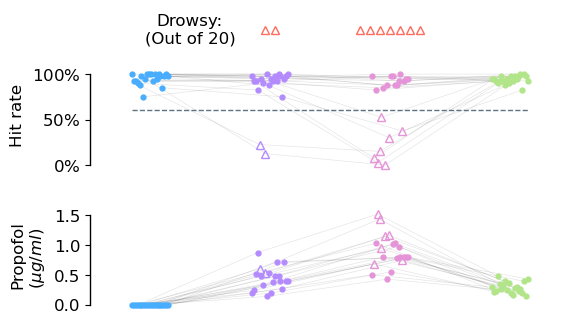

In [6]:
# %% Draw behavior and propofol concentration statistics

def draw_four_state_statistics(ax, ys):
    classes = np.tile([0, 1, 2, 3], 20)
    pos = np.linspace(-0.15, 0.15, 20, True)
    for i in range(20):
        plt.plot(np.arange(4) + pos[i], ys[i * 4 : (i + 1) * 4], lw = 0.5, c = "#000000", alpha = 0.1, zorder = -10)
    for i in range(4):
        mask0 = classes == i
        for j in range(2):
            mask1 = unresponsive == bool(j)
            mask = mask0 & mask1
            if mask.sum() == 0:
                continue
            plt.plot((pos + i)[mask[i : : 4]], ys[mask], [".", "^"][j], fillstyle = ["full", "none"][j], ms = [7, 6][j], c = state_colors[i])
    
    ax.set_xticks([])
    ax.tick_params(labelsize = "large")
    ax.set_frame_on(False)
    plt.axis(xmin = -0.5, xmax = 3.5)

fx, fy = 5.7, 3.2
fig = plt.figure(figsize = [fx, fy])
ax = plt.axes([0.9 / fx, 1.5 / fy, 4.8 / fx, 1 / fy])
draw_four_state_statistics(ax, qs / 40 * 100)
ax.set_yticks([0, 50, 100])
ax.set_yticklabels(["$0\%$", "$50\%$", "$100\%$"])
plt.plot([-0.5] * 2, [0, 100], lw = 1, c = "#000000", clip_on = False)
plt.plot([-0.15, 3.15], [60] * 2, lw = 1, c = default_color, ls = "--", zorder = -10)
fig.text(0.1 / fx, (1.5 + 1.1 / 2) / fy, r"Hit rate", ha = "left", va = "center", rotation = 90, size = "large")

ax = plt.axes([0.9 / fx, 0.1 / fy, 4.8 / fx, 1 / fy])
draw_four_state_statistics(ax, ppfc / 1000)
ax.set_yticks([0, 0.5, 1, 1.5])
plt.plot([-0.5] * 2, [0, 1.5], lw = 1, c = "#000000", clip_on = False)
fig.text(0.1 / fx, (0.1 + 1.1 / 2) / fy, "Propofol\n" + r"($\mu g/ml$)", ha = "left", va = "center", rotation = 90, size = "large")

ax = plt.axes([0.9 / fx, 2.7 / fy, 4.8 / fx, 0.4 / fy])
plt.axis([0, 4.8, 0, 0.4])
plt.text(1, 0.2, "Drowsy:\n(Out of 20)", ha = "center", va = "center", size = "large")
for i in [1, 2]:
    tmp_n_unresp = unresponsive[i : : 4].sum()
    plt.plot((np.arange(tmp_n_unresp) - (tmp_n_unresp - 1) / 2) * 0.1 + i * 1.2 + 0.6, [0.2] * tmp_n_unresp, \
              "^", fillstyle = "none", ms = 6, c = unresp_color)
vis.no_axes(ax)

fig.savefig(fig_path + "dataset_statistics.svg", format = "svg")

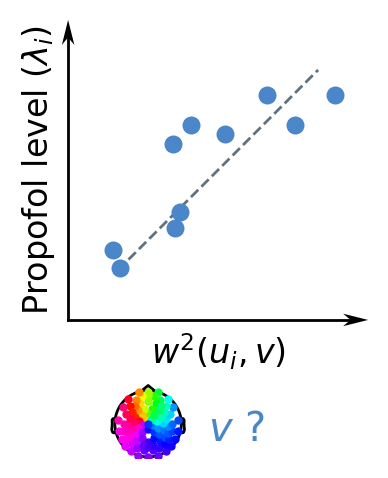

In [10]:
# %% Draw EW-WOCCA diagram

fx, fy = 1.9, 2.4
fig = plt.figure(figsize = [fx, fy], dpi = 200)
ax = plt.axes([0.3 / fx, 0.8 / fy, 1.5 / fx, 1.5 / fy])
plt.axis([0, 1.2, 0, 1.2])
plt.plot([0, 1.13], [0, 0], lw = 1, c = "#000000", clip_on = False)
plt.arrow(1, 0, 0.2, 0, length_includes_head = True, width = 0, head_length = 0.1, head_width = 0.05, head_starts_at_zero = False, overhang = 0.3, \
          fc = "#000000", ec = "#00000000", lw = 1, zorder = 10, clip_on = False)
plt.plot([0, 0], [0, 1.13], lw = 1, c = "#000000", clip_on = False)
plt.arrow(0, 1, 0, 0.2, length_includes_head = True, width = 0, head_length = 0.1, head_width = 0.05, head_starts_at_zero = False, overhang = 0.3, \
          fc = "#000000", ec = "#00000000", lw = 1, zorder = 10, clip_on = False)

random_state = np.random.RandomState(seed = 1)
tmp_xs = random_state.random(size = [10]) * 0.5 + np.linspace(0, 0.8, 10, True)
tmp_ys = random_state.random(size = [10]) * 0.5 + np.linspace(0, 0.8, 10, True)
plt.scatter(tmp_xs, tmp_ys, s = 30, c = diagram_scatter_color)
plt.plot([0.2, 1], [0.2, 1], "--", lw = 1, c = default_color, zorder = -10)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel(r"$w^2(u_i,v)$", size = "large")
plt.ylabel(r"Propofol level (${\lambda}_i$)", size = "large")

ax = plt.axes([0.5 / fx, 0.1 / fy, 0.4 / fx, 0.4 / fy])
vis.disp_phasemap(info, ws_ew[1], markersize = 4)
fig.text(1 / fx, 0.25 / fy, "$v$ ?", size = "x-large", ha = "left", va = "center", color = diagram_scatter_color)

fig.savefig(fig_path + "ew_wocca_diagram.svg", format = "svg")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91


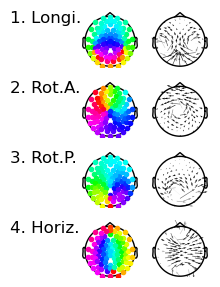

In [11]:
# %% Draw EW-WOCCA phasemaps

fx, fy = 2.1, 2.7
fig = plt.figure(figsize = [fx, fy])
for i in range(4):
    fig.text(0, (0.7 * (3 - i) + 0.5) / fy, "{:}. {:}".format(i + 1, comp_labels_ew[i]), ha = "left", va = "center", size = "large")
    ax = plt.axes([0.7 / fx, 0.7 * (3 - i) / fy, 0.6 / fx, 0.6 / fy])
    vis.disp_phasemap(info, ws_ew[i], markersize = 6)
    ax = plt.axes([1.4 / fx, 0.7 * (3 - i) / fy, 0.6 / fx, 0.6 / fy])
    vis.disp_quiver_map(info, ws_ew[i], show_r2 = True, sensors = False, scale = 60, width = 0.01)

fig.savefig(fig_path + "ew_wocca_comps.svg", format = "svg")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
[-0.02293907  0.06856494] [-0.00737351 -0.22338161]
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91


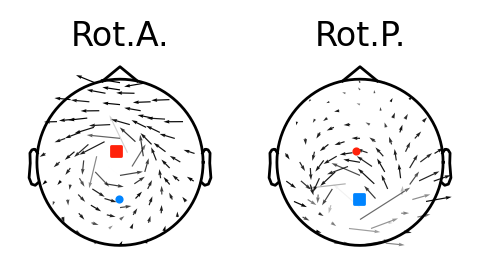

In [10]:
# %% Draw Rot.A and Rot.P rotation centers

rc_ew1 = gradient.fit_rotation_center(info, ws_ew[1], target = 1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
rc_ew2 = gradient.fit_rotation_center(info, ws_ew[2], target = 1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
print(rc_ew1, rc_ew2)

tmp_s0_c = vis.sat_mod_white(state_colors[0], 0.5)
tmp_unresp_c = vis.sat_mod_white(unresp_color, 0.5)
fx, fy = 2.2, 1.2
fig = plt.figure(figsize = [fx, fy], dpi = 200)

ax = plt.axes([0, 0, 1 / fx, 1 / fy])
vis.disp_quiver_map(info, ws_ew[1], show_r2 = True, sensors = False, scale = 60, width = 0.006)
plt.scatter(rc_ew1[0], rc_ew1[1], s = 15, marker = "s", c = tmp_unresp_c)
plt.scatter(rc_ew2[0], rc_ew2[1], s = 15, marker = ".", c = tmp_s0_c)

ax = plt.axes([1.2 / fx, 0, 1 / fx, 1 / fy])
vis.disp_quiver_map(info, ws_ew[2], show_r2 = True, sensors = False, scale = 60, width = 0.006)
plt.scatter(rc_ew1[0], rc_ew1[1], s = 15, marker = ".", c = tmp_unresp_c)
plt.scatter(rc_ew2[0], rc_ew2[1], s = 15, marker = "s", c = tmp_s0_c)

fig.text(0.5 / fx, 1 / fy, comp_labels_ew[1], ha = "center", va = "bottom", size = "large", )
fig.text(1.7 / fx, 1 / fy, comp_labels_ew[2], ha = "center", va = "bottom", size = "large")

fig.savefig(fig_path + "ew_wocca_gradient_analysis.svg", format = "svg")

In [55]:
# %% Prepare statistics

def average_per_session(v):
    if len(v.shape) == 1:
        res = np.zeros([n_subjs, n_states], dtype = v.dtype)
    else:
        res = np.zeros([n_subjs, n_states, v.shape[1]], dtype = v.dtype)

    l = 0
    for i in range(n_subjs):
        for j in range(n_states):
            p = bounds[segs_states[i, j]]
            q = bounds[segs_states[i, j + 1]]
            res[i, j] = v[p : q].mean(axis = 0)

    return res.reshape([n_subjs * n_states, -1])

asym_ew = average_per_session(projs_ew)
energy_ew = average_per_session(projs_ew ** 2)

### EW-WOCCA correlation with baseline

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91


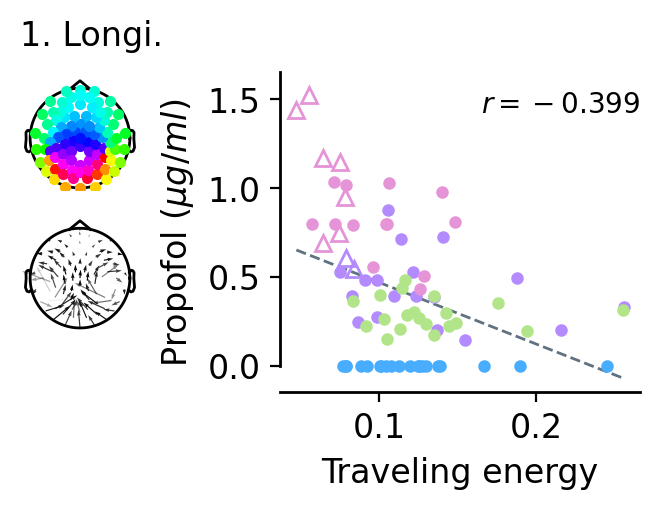

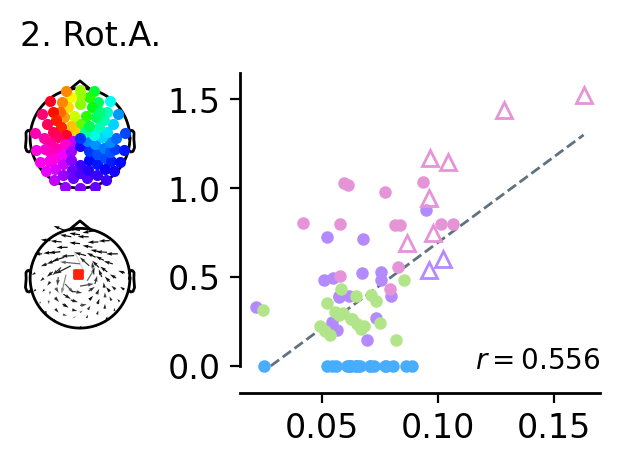

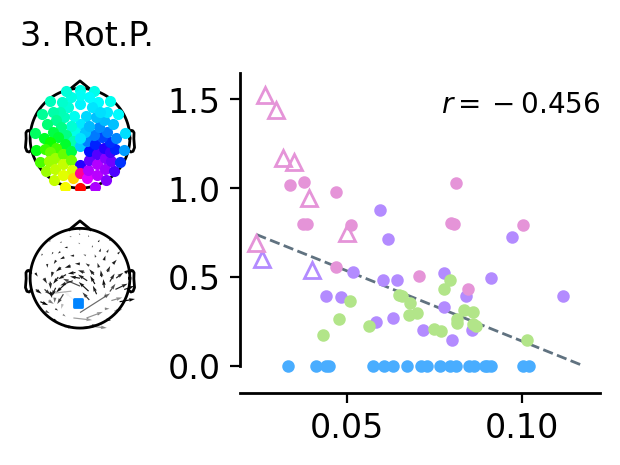

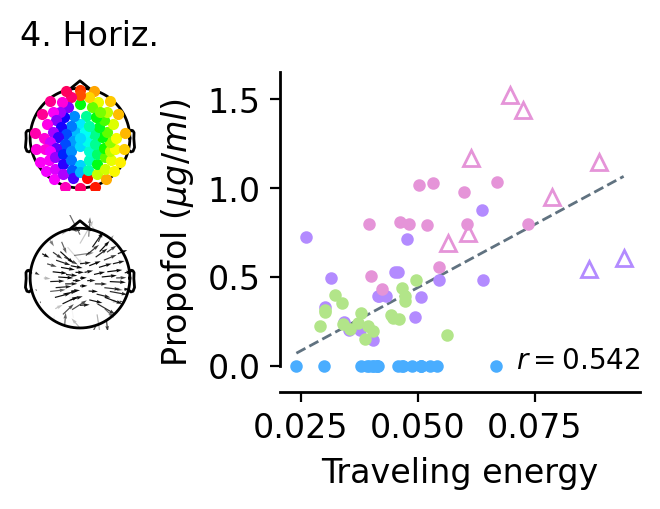

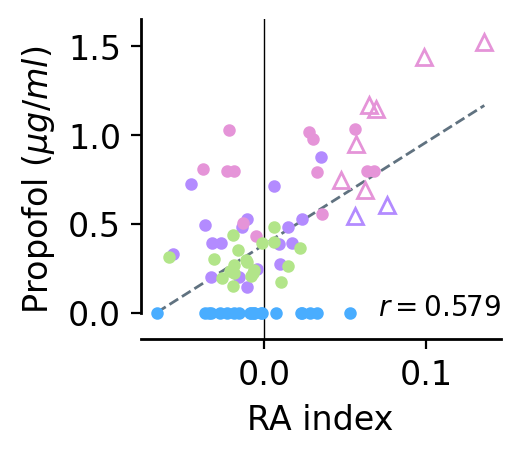

In [14]:
# %% Draw correlation with propofol levels

def draw_ppfc_correlation(ax, xs, r_pos):
    classes = np.tile([0, 1, 2, 3], 20)
    for i in range(4):
        mask0 = classes == i
        for j in range(2):
            mask1 = unresponsive == bool(j)
            mask = mask0 & mask1
            if mask.sum() == 0:
                continue

            plt.plot(xs[mask], ppfc[mask] / 1000, [".", "^"][j], fillstyle = ["full", "none"][j], ms = [7, 6][j], c = state_colors[i])
    
    ax.tick_params(labelsize = "large")
    ax.set_frame_on(False)

    xmin, xmax = xs.min(), xs.max()
    ymin, ymax = ppfc.min() / 1000, ppfc.max() / 1000
    
    k, b = np.polyfit(xs, ppfc / 1000, deg = 1)
    j0, j1 = xmin, xmax
    if k < 0:
        if k * xmin + b > ymax:
            j0 = (ymax - b) / k
        if k * xmax + b > ymin:
            j1 = (ymin - b) / k
    if k > 0:
        if k * xmin + b < ymin:
            j0 = (ymin - b) / k
        if k * xmax + b > ymax:
            j1 = (ymax - b) / k

    plt.plot([j0, j1], [j0 * k + b, j1 * k + b], "--", lw = 1, c = default_color, zorder = -10)

    axh = plt.axis(ymin = -0.15, ymax = 1.65)
    plt.axis(axh)

    r = np.corrcoef(xs, ppfc)[0, 1]
    plt.text(axh[1], 1.55 if r_pos == "up" else -0.05, "$r={:.3f}$".format(r).replace("-", vis.minus_sign), \
             ha = "right", va = "top" if r_pos == "up" else "bottom", size = "medium")
    
    plt.axhline(y = axh[2], lw = 1, c = "#000000", clip_on = False)
    plt.axvline(x = axh[0], ymin = -axh[2] / (axh[3] - axh[2]), lw = 1, c = "#000000", clip_on = False)

for i in range(4):
    with_ylabel = i in [0, 3]
    with_xlabel = i in [0, 3]
    yl_offset = int(with_ylabel) * 0.2
    xl_offset = int(with_xlabel) * 0.2
    
    fx, fy = 3.1 + yl_offset, 2.3 + xl_offset
    fig = plt.figure(figsize = [fx, fy], dpi = 200)
    fig.text(0.1 / fx, (2 + xl_offset) / fy, str(i + 1) + ". " + comp_labels_ew[i], ha = "left", va = "bottom", size = "large")
    ax = plt.axes([0.1 / fx, (1.3 + xl_offset) / fy, 0.6 / fx, 0.6 / fy])
    vis.disp_phasemap(info, ws_ew[i], markersize = 6)
    ax = plt.axes([0.1 / fx, (0.6 + xl_offset) / fy, 0.6 / fx, 0.6 / fy])
    vis.disp_quiver_map(info, ws_ew[i], show_r2 = True, sensors = False, scale = 60, width = 0.01)
    if i in [1, 2]:
        tmp_rc = gradient.fit_rotation_center(info, ws_ew[i], target = 1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
        plt.scatter(tmp_rc[0], tmp_rc[1], s = 10, marker = "s", c = [tmp_unresp_c, tmp_s0_c][i - 1])
    
    ax = plt.axes([(1.2 + yl_offset) / fx, (0.3 + xl_offset) / fy, 1.8 / fx, 1.6 / fy])
    draw_ppfc_correlation(ax, energy_ew[ : , i], ["up", "down", "up", "down"][i])

    if with_ylabel:
        plt.ylabel("Propofol ($\mu g/ml$)", size = "large")
    if with_xlabel:
        plt.xlabel("Traveling energy", size = "large")

    fig.savefig(fig_path + "propofol_correlation_" + comp_names_ew[i] + ".svg", format = "svg")

fx, fy = 2.5, 2.2
fig = plt.figure(figsize = [fx, fy], dpi = 200)
ax = plt.axes([0.6 / fx, 0.5 / fy, 1.8 / fx, 1.6 / fy])
draw_ppfc_correlation(ax, energy_ew[ : , 1] - energy_ew[ : , 2], "down")
axh = plt.axis()
plt.axvline(x = 0, lw = 0.5, c = "#000000", zorder = -20)
plt.xlabel(axis_labels[2], size = "large")
plt.ylabel("Propofol ($\mu g/ml$)", size = "large")
fig.savefig(fig_path + "propofol_correlation_rotant.svg", format = "svg")

(0.10296979968621182, 0.914264435601544, 0.3633955345257678)


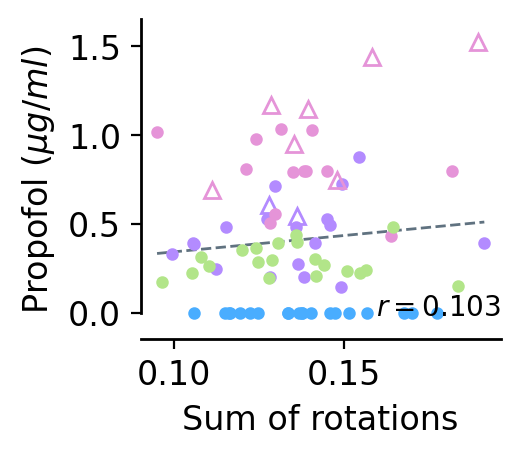

In [88]:
# %% Draw correlation of propofol levels with sum of rot

fx, fy = 2.5, 2.2
fig = plt.figure(figsize = [fx, fy], dpi = 200)
ax = plt.axes([0.6 / fx, 0.5 / fy, 1.8 / fx, 1.6 / fy])
draw_ppfc_correlation(ax, energy_ew[ : , 1] + energy_ew[ : , 2], "down")
axh = plt.axis()
plt.axvline(x = 0, lw = 0.5, c = "#000000", zorder = -20)
plt.xlabel("Sum of rotations", size = "large")
plt.ylabel("Propofol ($\mu g/ml$)", size = "large")
fig.savefig(fig_path + "propofol_correlation_rotsum.svg", format = "svg")

print(core.pearson_t_test(energy_ew[ : , 1] + energy_ew[ : , 2], ppfc))

### EW-WOCCA correlation without baseline

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91
Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 91


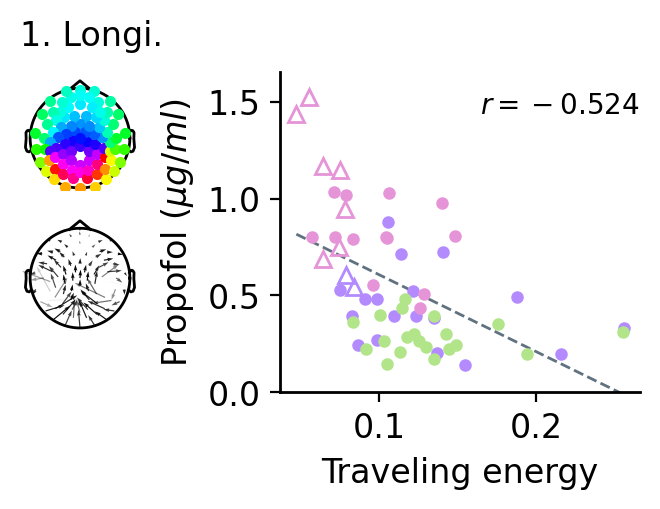

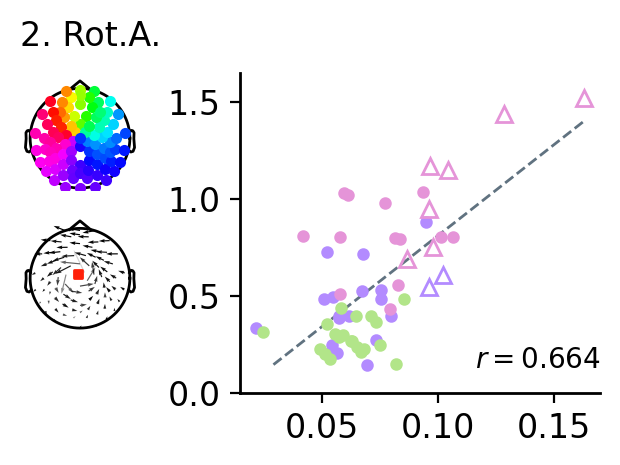

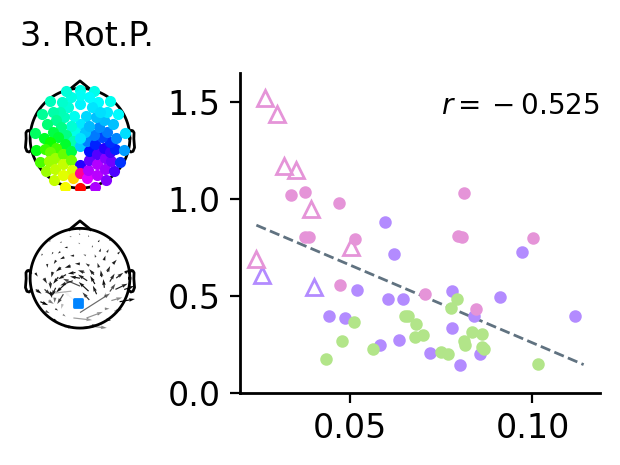

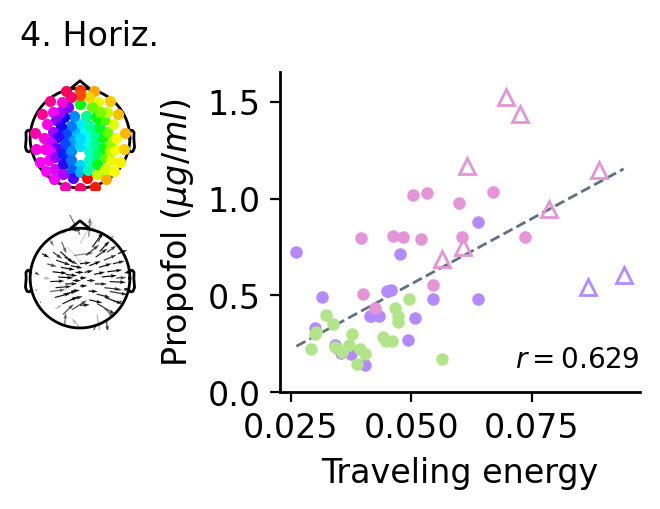

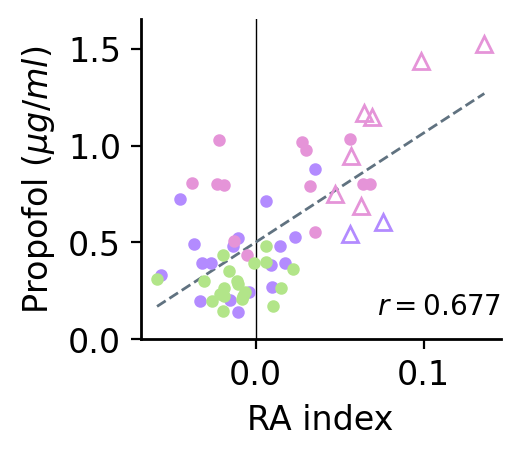

In [24]:
# %% Draw correlation with propofol levels

def draw_ppfc_correlation_no_base(ax, xs, r_pos):
    global_mask = np.ones([80], dtype = bool)
    global_mask[ : : 4] = False
    
    classes = np.tile([0, 1, 2, 3], 20)
    for i in range(1, 4):
        mask0 = classes == i
        for j in range(2):
            mask1 = unresponsive == bool(j)
            mask = mask0 & mask1
            if mask.sum() == 0:
                continue

            plt.plot(xs[mask], ppfc[mask] / 1000, [".", "^"][j], fillstyle = ["full", "none"][j], ms = [7, 6][j], c = state_colors[i])
    
    ax.tick_params(labelsize = "large")
    ax.set_frame_on(False)

    xmin, xmax = xs[global_mask].min(), xs[global_mask].max()
    ymin, ymax = ppfc[global_mask].min() / 1000, ppfc[global_mask].max() / 1000
    
    k, b = np.polyfit(xs[global_mask], ppfc[global_mask] / 1000, deg = 1)
    j0, j1 = xmin, xmax
    if k < 0:
        if k * xmin + b > ymax:
            j0 = (ymax - b) / k
        if k * xmax + b > ymin:
            j1 = (ymin - b) / k
    if k > 0:
        if k * xmin + b < ymin:
            j0 = (ymin - b) / k
        if k * xmax + b > ymax:
            j1 = (ymax - b) / k

    plt.plot([j0, j1], [j0 * k + b, j1 * k + b], "--", lw = 1, c = default_color, zorder = -10)

    axh = plt.axis(ymin = 0, ymax = 1.65)
    plt.axis(axh)

    r = np.corrcoef(xs[global_mask], ppfc[global_mask])[0, 1]
    plt.text(axh[1], 1.55 if r_pos == "up" else 0.1, "$r={:.3f}$".format(r).replace("-", vis.minus_sign), \
             ha = "right", va = "top" if r_pos == "up" else "bottom", size = "medium")
    
    plt.axhline(y = axh[2], lw = 1, c = "#000000", clip_on = False)
    plt.axvline(x = axh[0], lw = 1, c = "#000000", clip_on = False)

for i in range(4):
    with_ylabel = i in [0, 3]
    with_xlabel = i in [0, 3]
    yl_offset = int(with_ylabel) * 0.2
    xl_offset = int(with_xlabel) * 0.2
    
    fx, fy = 3.1 + yl_offset, 2.3 + xl_offset
    fig = plt.figure(figsize = [fx, fy], dpi = 200)
    fig.text(0.1 / fx, (2 + xl_offset) / fy, str(i + 1) + ". " + comp_labels_ew[i], ha = "left", va = "bottom", size = "large")
    ax = plt.axes([0.1 / fx, (1.3 + xl_offset) / fy, 0.6 / fx, 0.6 / fy])
    vis.disp_phasemap(info, ws_ew[i], markersize = 6)
    ax = plt.axes([0.1 / fx, (0.6 + xl_offset) / fy, 0.6 / fx, 0.6 / fy])
    vis.disp_quiver_map(info, ws_ew[i], show_r2 = True, sensors = False, scale = 60, width = 0.01)
    if i in [1, 2]:
        tmp_rc = gradient.fit_rotation_center(info, ws_ew[i], target = 1, init = [0, 0], weight_scale = [0.1, 0.3])[0]
        plt.scatter(tmp_rc[0], tmp_rc[1], s = 10, marker = "s", c = [tmp_unresp_c, tmp_s0_c][i - 1])
    
    ax = plt.axes([(1.2 + yl_offset) / fx, (0.3 + xl_offset) / fy, 1.8 / fx, 1.6 / fy])
    draw_ppfc_correlation_no_base(ax, energy_ew[ : , i], ["up", "down", "up", "down"][i])

    if with_ylabel:
        plt.ylabel("Propofol ($\mu g/ml$)", size = "large")
    if with_xlabel:
        plt.xlabel("Traveling energy", size = "large")

    fig.savefig(fig_path + "propofol_correlation_" + comp_names_ew[i] + "_no_base.svg", format = "svg")

fx, fy = 2.5, 2.2
fig = plt.figure(figsize = [fx, fy], dpi = 200)
ax = plt.axes([0.6 / fx, 0.5 / fy, 1.8 / fx, 1.6 / fy])
draw_ppfc_correlation_no_base(ax, energy_ew[ : , 1] - energy_ew[ : , 2], "down")
axh = plt.axis()
plt.axvline(x = 0, lw = 0.5, c = "#000000", zorder = -20)
plt.xlabel(axis_labels[2], size = "large")
plt.ylabel("Propofol ($\mu g/ml$)", size = "large")
fig.savefig(fig_path + "propofol_correlation_rotant_no_base.svg", format = "svg")

(0.10296979968621182, 0.914264435601544, 0.3633955345257678)


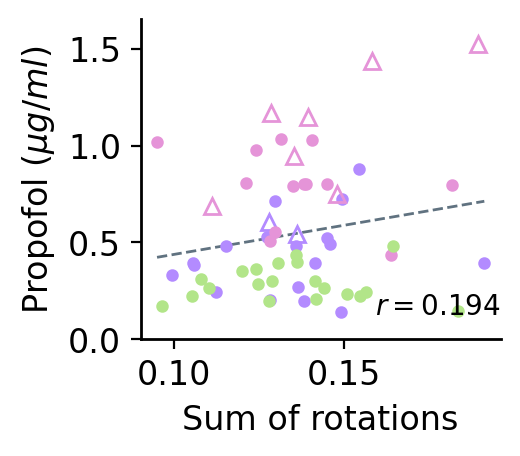

In [17]:
# %% Draw correlation of propofol levels with sum of rot

fx, fy = 2.5, 2.2
fig = plt.figure(figsize = [fx, fy], dpi = 200)
ax = plt.axes([0.6 / fx, 0.5 / fy, 1.8 / fx, 1.6 / fy])
draw_ppfc_correlation_no_base(ax, energy_ew[ : , 1] + energy_ew[ : , 2], "down")
axh = plt.axis()
plt.axvline(x = 0, lw = 0.5, c = "#000000", zorder = -20)
plt.xlabel("Sum of rotations", size = "large")
plt.ylabel("Propofol ($\mu g/ml$)", size = "large")
fig.savefig(fig_path + "propofol_correlation_rotsum_no_base.svg", format = "svg")

print(core.pearson_t_test(energy_ew[ : , 1] + energy_ew[ : , 2], ppfc))

### Dynamics of loss of consciousness

In [22]:
def extract_mean_seg(v):
    if v.ndim == 1:
        p = np.zeros([n_segs], dtype = v.dtype)
    else:
        p = np.zeros([n_segs, v.shape[1]], dtype = v.dtype)

    for i in range(n_segs):
        p[i] = v[bounds[i] : bounds[i + 1]].mean(axis = 0)

    return p

def compute_progress_mean(p, minus_baseline = False):
    if minus_baseline:
        p = p.copy()
        for i in range(20):
            p[segs_states[i, 0] : segs_states[i, 4]] -= p[segs_states[i, 0] : segs_states[i, 1]].mean(axis = 0)
    
    n_seg_max = ids[ : , 2].max() + 1
    if len(p.shape) == 1:
        r_sum = np.zeros([4, n_seg_max], dtype = p.dtype)
    else:
        r_sum = np.zeros([4, n_seg_max, p.shape[1]], dtype = p.dtype)
    r_sqsum = np.zeros_like(r_sum)
    r_n = np.zeros([4, n_seg_max], dtype = int)
    
    for i in range(n_segs):
        r_n[ids[i, 1], ids[i, 2]] += 1
        r_sum[ids[i, 1], ids[i, 2]] += p[i]
        r_sqsum[ids[i, 1], ids[i, 2]] += p[i] ** 2
    
    r_mean = np.zeros_like(r_sum)
    r_std = np.zeros_like(r_sum)
    for i in range(4):
        for j in range(n_seg_max):
            if r_n[i, j] != 0:
                r_mean[i, j] = r_sum[i, j] / r_n[i, j]
                if r_n[i, j] > 1:
                    r_std[i, j] = np.sqrt((r_sqsum[i, j] - r_n[i, j] * (r_mean[i, j] ** 2)) / (r_n[i, j] - 1))
    
    return r_mean, r_std, r_n

def plot_progress(r_mean, r_std, r_n, ax = None, with_xaxis = False, alpha_ci = 0.05, base_colors = ["#606060"] * 4):
    if ax == None:
        ax = plt.gca()
    n = 40
    
    w = 0.1
    v = 0.15
    x = 0.025
    
    p_last = w
    for i in range(4):
        xs = p_last + np.arange(n) * x + x / 2
        plt.plot(xs, r_mean[i, : n], c = vis.sat_mod_white(base_colors[i], 0.5))
        plt.plot([p_last, p_last + n * x], [0, 0], lw = 1, c = "#000000", ls = "--", alpha = 0.5, zorder = -20)
        p_last += n * x + v
    
    axl0 = plt.axis()
    yrng = np.abs(axl0[2 : ]).max()
    axl = plt.axis(xmin = 0, xmax = p_last - v + w, ymin = -yrng, ymax = yrng)
    
    p_last = w
    plt.fill_betweenx([axl[2] - 1, axl[3] + 1], [0] * 2, [w] * 2, fc = vis.append_alpha("#000000", 0.05), ec = "#00000000", zorder = -10)
    for i in range(4):
        xs = p_last + np.arange(n) * x + x / 2
        cs = np.zeros([n])
        for j in range(n):
            cs[j] = stats.t(r_n[i, j] - 1).ppf(1 - alpha_ci / 2) * r_std[i, j] / np.sqrt(r_n[i, j])
        plt.fill_between(xs, r_mean[i, : n] - cs, r_mean[i, : n] + cs, fc = vis.append_alpha(base_colors[i], 0.3), ec = "#00000000", zorder = -10)
        p_last += n * x + v
        if i != 3:
            plt.fill_betweenx([axl[2] - 1, axl[3] + 1], [p_last - v] * 2, [p_last] * 2, fc = vis.append_alpha("#000000", 0.05), ec = "#00000000", zorder = -10)
    plt.fill_betweenx([axl[2] - 1, axl[3] + 1], [p_last - v] * 2, [p_last - v + w] * 2, fc = vis.append_alpha("#000000", 0.05), ec = "#00000000", zorder = -10)
    
    plt.axis(axl)
    
    ax.tick_params(labelsize = "large")
    ax.set_frame_on(False)
    plt.axvline(x = axl[0], lw = 1, c = "#000000", clip_on = False, zorder = -20)
    if with_xaxis:
        xticks = []
        xticklabels = []
        center_pos = []
        p_last = w
        for i in range(4):
            plt.plot([p_last, p_last + x * n], [axl[2]] * 2, lw = 1, c = "#000000", clip_on = False, zorder = -20)
            xticks += list(p_last + np.linspace(0, n, 3, True) * x)
            if i == 0:
                xticklabels += ["{:.0f}".format(k * 10) for k in np.linspace(0, n, 3, True)]
            else:
                xticklabels += [""] + ["{:.0f}".format(k * 10) for k in np.linspace(0, n, 3, True)[1 : ]]
            center_pos.append((p_last + n * x / 2) / axl[1])
            p_last += n * x + v
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        
        return center_pos
    
    ax.set_xticks([])

In [24]:
segs_te_ew = extract_mean_seg(projs_ew ** 2)
prog_mean_ew, prog_std_ew, prog_n = compute_progress_mean(segs_te_ew, minus_baseline = True)
prog_mean_ra, prog_std_ra, _ = compute_progress_mean(segs_te_ew[ : , 1] - segs_te_ew[ : , 2], minus_baseline = True)

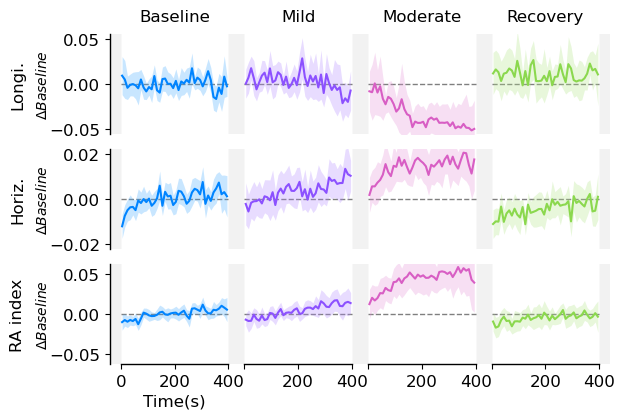

In [32]:
# %% Draw curves

fx, fy = 6.2, 4.2
fig = plt.figure(figsize = [fx, fy])
plt.axes([1.1 / fx, (0.5 + 1.15 * 2) / fy, 5 / fx, 1 / fy])
plot_progress(prog_mean_ew[..., 0], prog_std_ew[..., 0], prog_n, with_xaxis = False, base_colors = state_colors)
plt.axes([1.1 / fx, (0.5 + 1.15) / fy, 5 / fx, 1 / fy])
plot_progress(prog_mean_ew[..., 3], prog_std_ew[..., 3], prog_n, with_xaxis = False, base_colors = state_colors)
plt.axes([1.1 / fx, 0.5 / fy, 5 / fx, 1 / fy])
center_pos = plot_progress(prog_mean_ra, prog_std_ra, prog_n, with_xaxis = True, base_colors = state_colors)

fig.text((1.1 + center_pos[0] * 5) / fx, 0.05 / fy, "Time(s)", size = "large", ha = "center", va = "bottom")
for i in range(4):
    fig.text((1.1 + center_pos[i] * 5) / fx, 1 - 0.3 / fy, state_names_full[i], size = "large", ha = "center", va = "bottom")
for i in range(3):
    fig.text(0.1 / fx, (0.5 + 1.15 * (2 - i) + 0.5) / fy, axis_labels[i], size = "large", ha = "left", va = "center", rotation = 90)
    fig.text(0.35 / fx, (0.5 + 1.15 * (2 - i) + 0.5) / fy, r"$\Delta Baseline$", size = "medium", ha = "left", va = "center", rotation = 90)

fig.savefig(fig_path + "progress_curves.svg", format = "svg")

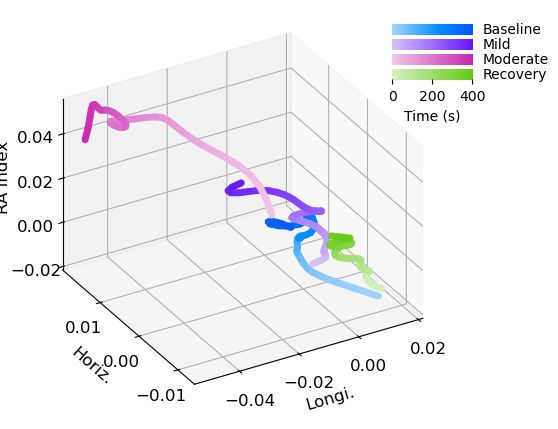

In [33]:
# %% Draw 3D trajectory

# Trajectory in 3D
fx, fy = 5.7, 4.2
fig = plt.figure(figsize = [fx, fy])
ax = plt.axes([0.5 / fx, 0.1 / fy, 4.1 / fx, 4.1 / fy], projection = "3d")
low_pass = signal.butter(2, 0.01, btype = "low", output = "sos", fs = 0.1)
org_jet_pos = [0.5, 0.7, 0.85, 0.3]
for i in range(4):
    tx = signal.sosfiltfilt(low_pass, prog_mean_ew[i, : 40, 0])
    ty = signal.sosfiltfilt(low_pass, prog_mean_ew[i, : 40, 3])
    tz = signal.sosfiltfilt(low_pass, prog_mean_ra[i, : 40])
    for j in range(39):
        j_rel = (j + 1) / 40
        tmp_cj = vis.sat_mod_white(state_colors[i], j_rel * 1.5 - 0.5)
        plt.plot(tx[j : j + 2], ty[j : j + 2], tz[j : j + 2], color = tmp_cj, alpha = 1, lw = 5, solid_capstyle = "round")

ax.set_xlabel(axis_labels[0], size = "large")
ax.set_ylabel(axis_labels[1], size = "large")
ax.set_zlabel(axis_labels[2], size = "large")
ax.set_xticks([-0.04, -0.02, 0, 0.02])
ax.set_yticks([-0.01, 0, 0.01])
ax.set_zticks([-0.02, 0, 0.02, 0.04])
ax.tick_params(labelsize = "large")
ax.set_proj_type("ortho")
ax.view_init(elev = 30, azim = -120)

# Colorbars
for i in range(4):
    ax = plt.axes([4.1 / fx, (3.5 + (3 - i) * 0.15) / fy, 0.8 / fx, 0.1 / fy])
    if i == 3:
        ax.tick_params(labelsize = "medium")
        ax.set_xticks([0, 20, 40])
        ax.set_xticklabels([0, 200, 400])
        plt.xlabel("Time (s)", size = "medium")
    else:
        ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)
    
    for j in range(40):
        j_rel = (j + 0.5) / 40
        tmp_cj = vis.sat_mod_white(state_colors[i], j_rel * 1.5 - 0.5)
        plt.fill_betweenx([0, 1], [j - 0.01, j - 0.01], [j + 1.01, j + 1.01], fc = tmp_cj, ec = tmp_cj, alpha = 1)
    plt.axis([0, 40, 0, 1])
    
    fig.text(5 / fx, (3.5 + (3 - i) * 0.15 + 0.05) / fy, state_names_full[i], size = "medium", ha = "left", va = "center")

fig.savefig(fig_path + "progress_3d.svg", format = "svg")

### Controling EW-WOCCA result statistics

In [52]:
# %% Definitions

n_comps_perm = 4
n_comps_perm_ext = 6
n_dim_pca = 30
tri_mask = wocca.upper_triangle(n_dim_pca)

In [25]:
# %% Compute b matrices per segment

# Load data
v = []
for i in range(n_fn_full):
    tmp = iter_twms(i)
    for j in range(len(tmp)):
        v.append(tmp[j].data.copy())

v = np.concatenate(v)
bounds = np.array(bounds)
n_data, n_v = v.shape

# Get average weight (to subtract from ppfc)
state_lens = np.zeros([n_subjs, n_states], dtype = int)
for i in range(n_subjs):
    for j in range(n_states):
        state_lens[i, j] = bounds[segs_states[i, j + 1]] - bounds[segs_states[i, j]]

# Get b matrices
u, pca_basis = wocca.pca_decomp(v, n_dim_pca)
b_states = np.zeros([n_subjs, n_states] + [(n_dim_pca - 1) * n_dim_pca // 2] * 2)
for i in range(n_subjs):
    for j in range(n_states):
        b_states[i, j] = wocca.get_b_matrix(u[bounds[segs_states[i, j]] : bounds[segs_states[i, j + 1]]], tri_mask, use_torch = True)
        print("Finished: {:}-{:}".format(i + 1, j + 1))

# Save PCA basis and b matrices
with open(partial_b_matrices_fn, mode = "wb") as FOut:
    pickle.dump((state_lens, pca_basis, b_states), FOut)

/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/02-2010-anest 20100210 135.003.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/02-2010-anest 20100210 135.006.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/02-2010-anest 20100210 135.014.set...
Not setting metadata
35 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/02-2010-anest- 20100210 16.003.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/03-2010-anest 20100211 142.003.set...
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/03-2010-anest 20100211 142.008.set...
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/03-2010-anest 20100211 142.021.set...
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/03-2010-anest 20100211 142.026.set...
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/05-2010-anest 20100223 095.004.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/05-2010-anest 20100223 095.009.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/05-2010-anest 20100223 095.022.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/05-2010-anest 20100223 095.027.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/06-2010-anest 20100224 093.003.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/06-2010-anest 20100224 093.008.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/06-2010-anest 20100224 093.013.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/06-2010-anest 20100224 093.026.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/07-2010-anest 20100226 133.003.set...
Not setting metadata
27 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/07-2010-anest 20100226 133.008.set...
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/07-2010-anest 20100226 133.021.set...
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/07-2010-anest 20100226 133.027.set...
Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/08-2010-anest 20100301 095.004.set...
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/08-2010-anest 20100301 095.010.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/08-2010-anest 20100301 095.015.set...
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/08-2010-anest 20100301 095.028.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/09-2010-anest 20100301 135.003.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/09-2010-anest 20100301 135.008.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/09-2010-anest 20100301 135.021.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/09-2010-anest 20100301 135.026.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/10-2010-anest 20100305 130.005.set...
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/10-2010-anest 20100305 130.010.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/10-2010-anest 20100305 130.015.set...
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/10-2010-anest 20100305 130.028.set...
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/13-2010-anest 20100322 132.003.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/13-2010-anest 20100322 132.008.set...
Not setting metadata
43 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/13-2010-anest 20100322 132.013.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/13-2010-anest 20100322 132.026.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/14-2010-anest 20100324 125.007.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/14-2010-anest 20100324 132.011.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/14-2010-anest 20100324 132.016.set...
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/14-2010-anest 20100324 132.031.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/18-2010-anest 20100331 140.003.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/18-2010-anest 20100331 140.009.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/18-2010-anest 20100331 140.014.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/18-2010-anest 20100331 140.027.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/20-2010-anest 20100414 131.004.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/20-2010-anest 20100414 131.009.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions m

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/20-2010-anest 20100414 131.022.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/20-2010-anest 20100414 131.027.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/22-2010-anest 20100415 132.004.set...
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/22-2010-anest 20100415 132.009.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/22-2010-anest 20100415 132.014.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/22-2010-anest 20100415 154.003.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/23-2010-anest 20100420 094.003.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/23-2010-anest 20100420 094.008.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/23-2010-anest 20100420 094.022.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions m

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/23-2010-anest 20100420 094.027.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/24-2010-anest 20100420 134.003.set...
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/24-2010-anest 20100420 134.010.set...
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/24-2010-anest 20100420 134.015.set...
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/24-2010-anest 20100420 134.028.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/25-2010-anest 20100422 133.003.set...
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/25-2010-anest 20100422 133.008.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/25-2010-anest 20100422 133.021.set...
Not setting metadata
36 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/25-2010-anest 20100422 133.026.set...
Not setting metadata
34 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/26-2010-anest 20100507 132.003.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/26-2010-anest 20100507 132.008.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/26-2010-anest 20100507 132.013.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/26-2010-anest 20100507 132.026.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/27-2010-anest 20100823 104.001.set...
Not setting metadata
38 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/27-2010-anest 20100823 104.010.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/27-2010-anest 20100823 104.023.set...
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/27-2010-anest 20100823 104.028.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/28-2010-anest 20100824 092.004.set...
Not setting metadata
37 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/28-2010-anest 20100824 092.011.set...
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/28-2010-anest 20100824 092.016.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/28-2010-anest 20100824 092.029.set...
Not setting metadata
39 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/29-2010-anest 20100921 142.005.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/29-2010-anest 20100921 142.010.set...
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/29-2010-anest 20100921 142.023.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/pymatreader/utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Extracting parameters from /data/liyichao/code/microstates/wocca_project_code/../data/sedation/29-2010-anest 20100921 142.028.set...
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 7 - 13 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 7.00, 13.00 Hz: -6.02, -6.02 dB



/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Unknown types found, setting as type EEG:
ref: ['Cz']
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()
/data/liyichao/code/microstates/wocca_project_code/ds1_sedation.py:44: RuntimeWarning: Estimated head radius (0.9 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_epochs_eeglab(path + fn + ".set").load_data()


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using GPU: True
Finished: 1-1
Using GPU: True
Finished: 1-2
Using GPU: True
Finished: 1-3
Using GPU: True
Finished: 1-4
Using GPU: True
Finished: 2-1
Using GPU: True
Finished: 2-2
Using GPU: True
Finished: 2-3
Using GPU: True
Finished: 2-4
Using GPU: True
Finished: 3-1
Using GPU: True
Finished: 3-2
Using GPU: True
Finished: 3-3
Using GPU: True
Finished: 3-4
Using GPU: True
Finished: 4-1
Using GPU: True
Finished: 4-2
Using GPU: True
Finished: 4-3
Using GPU: True
Finished: 4-4
Using GPU: True
Finished: 5-1
Using GPU: True
Finished: 5-2
Using GPU: True
Finished: 5-3
Using GPU: True
Finished: 5-4
Using GPU: True
Finished: 6-1
Using GPU: True
Finished: 6-2
Using GPU: True
Finished: 6-3
Using GPU: True
Finished: 6-4
Using GPU: True
Finished: 7-1
Using GPU: True
Finished: 7-2
Using GPU: True
Finished: 7-3
Using GPU: True
Finished: 7-4
Using GPU: True
Finished: 8-1
Using GPU: True
Fin

In [26]:
# %% Permutation

n_perms = 1000
random_seed = 1
random_state = np.random.RandomState(random_seed)

# Reload b matrices
with open(partial_b_matrices_fn, mode = "rb") as FIn:
    state_lens, pca_basis, b_states = pickle.load(FIn)
n_v = pca_basis.shape[1]

# Permutated EW-WOCCA and correlation coefficients
global_mask = np.ones([80], dtype = bool)
global_mask[ : : 4] = False

perm_ws_ew = np.zeros([n_perms, n_comps_perm, n_v], dtype = complex)
perm_ppfc = np.zeros([n_perms, n_subjs, n_states])
perm_results = np.zeros([n_perms, n_comps_perm, 2])
for i in range(n_perms):
    perm_ppfc[i] = random_state.permutation(ppfc).reshape([n_subjs, n_states])
    tmp_weights_mean = (perm_ppfc[i] * state_lens).sum() / state_lens.sum()
    tmp_bw = (b_states * (perm_ppfc[i] - tmp_weights_mean).reshape([n_subjs, n_states, 1, 1])).sum(axis = 0).sum(axis = 0)
    tmp_ws_ew_pca = wocca.ew_wocca(None, None, bw = tmp_bw, n_components = n_comps_perm_ext, use_torch = True, backtrack = True, backtrack_max_iter = 50)
    perm_ws_ew[i] = wocca.pca_recover(tmp_ws_ew_pca[ : n_comps_perm], pca_basis)
    
    tmp_projs = wocca.projection(v, perm_ws_ew[i])
    tmp_energy = average_per_session(tmp_projs)
    for j in range(n_comps_perm):
        perm_results[i, j, 0] = np.corrcoef(tmp_energy[ : , j], perm_ppfc[i].flatten())[0, 1]
        perm_results[i, j, 1] = np.corrcoef(tmp_energy[global_mask, j], perm_ppfc[i].flatten()[global_mask])[0, 1]

# Save permutated components
with open(permutation_fn, mode = "wb") as FOut:
    pickle.dump((random_seed, perm_ws_ew, perm_ppfc, perm_results), FOut)

Iter 1 / 6
No. of iters 38
Score 2747910.5024437006 

Iter 2 / 6
No. of iters 50
Score 1596962.3909172982 

Iter 3 / 6
No. of iters 56
Score 1339608.4275363057 

Iter 4 / 6
No. of iters 77
Score 782069.2301985122 

Iter 5 / 6
No. of iters 50
Score 773302.0933973929 

Iter 6 / 6
No. of iters 63
Score 247141.43621756166 

Iter 1 / 6
No. of iters 31
Score 1769167.3687023364 

Iter 2 / 6
No. of iters 49
Score 1303053.3857058634 

Iter 3 / 6
No. of iters 46
Score 567707.1966022461 

Iter 4 / 6
No. of iters 73
Score 360255.2762817757 

Iter 5 / 6
No. of iters 43
Score 282352.78559827455 

Iter 6 / 6
No. of iters 57
Score 201841.71539644815 

Iter 1 / 6
No. of iters 35
Score 1964954.6072700492 



/home/liyichao/miniconda3/envs/mne/lib/python3.11/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Iter 2 / 6
No. of iters 46
Score 1238636.7525559743 

Iter 3 / 6
No. of iters 56
Score 428965.8614958457 

Iter 4 / 6
No. of iters 50
Score 378878.0519109697 

Iter 5 / 6
No. of iters 38
Score 270018.35331935575 

Iter 6 / 6
No. of iters 39
Score 167179.89307675214 

Iter 1 / 6
No. of iters 40
Score 1115311.7707088208 

Iter 2 / 6
No. of iters 52
Score 626681.6386352498 

Iter 3 / 6
No. of iters 52
Score 454120.1598414611 

Iter 4 / 6
No. of iters 82
Score 271436.68205848156 

Iter 5 / 6
No. of iters 49
Score 273430.73608520266 

Score not decreasing
Backtrack to Iter 4 

Iter 4 / 6
No. of iters 35
Score 294989.6552056194 

Iter 5 / 6
No. of iters 49
Score 244114.96515460216 

Iter 6 / 6
No. of iters 44
Score 173652.9360521634 

Iter 1 / 6
No. of iters 36
Score 1780431.996745987 

Iter 2 / 6
No. of iters 41
Score 993986.4730671013 

Iter 3 / 6
No. of iters 59
Score 507460.3936486244 

Iter 4 / 6
No. of iters 78
Score 317920.47533956735 

Iter 5 / 6
No. of iters 57
Score 247064.47705367

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [53]:
# Load permutation data
with open(permutation_fn, mode = "rb") as FIn:
    random_seed, perm_ws_ew, perm_ppfc, perm_results = pickle.load(FIn)

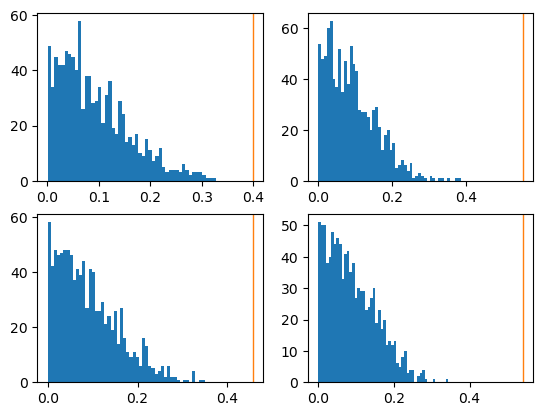

In [56]:
# Draw full data correlation

plt.figure(figsize = [6.4, 4.8])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.hist(np.abs(perm_results[ : , i, 0]), bins = 50)
    plt.axvline(x = np.abs(np.corrcoef(energy_ew[ : , i], ppfc)[0, 1]), lw = 1, c = vis.colors[1])

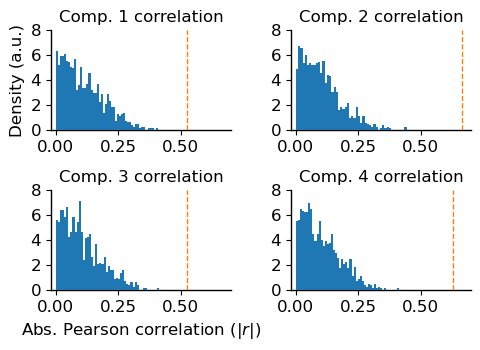

In [62]:
# %% Draw no baseline correlation

fx, fy = 4.8, 3.4
fig = plt.figure(figsize = [fx, fy])
for i in range(4):
    ix = i % 2
    iy = i // 2
    ax = plt.axes([(0.5 + 2.4 * ix) / fx, (0.5 + 1.6 * (1 - iy)) / fy, 1.8 / fx, 1 / fy])
    plt.hist(np.abs(perm_results[ : , i, 1]), density = 1 / len(perm_results), bins = 50)
    plt.axvline(x = np.abs(np.corrcoef(energy_ew[global_mask, i], ppfc[global_mask])[0, 1]), lw = 1, c = vis.colors[1], ls = "--")
    plt.axis([-0.02, 0.7, 0, 8])
    vis.lower_left(ax)
    ax.set_yticks([0, 2, 4, 6, 8])
    ax.tick_params(labelsize = "large")
    if i == 2:
        plt.xlabel("Abs. Pearson correlation ($|r|$)", size = "large")
    if i == 0:
        plt.ylabel("Density (a.u.)", size = "large")
    plt.title("Comp. {:} correlation".format(i + 1))
fig.savefig(fig_supp_path + "propofol_correlation_perm_by_comps.svg", format = "svg")